### Laboratorium 4 - zadania

In [171]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `tabby` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie **jednolitych**  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

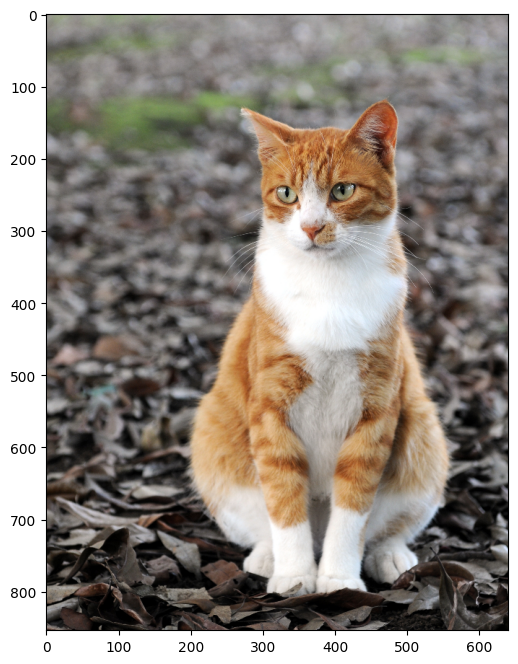

In [172]:
_ = cv2.imread("tabby.jpg")[..., ::-1]
tabby = cv2.resize(_, dsize=None, fx=0.3, fy=0.3)
plt.subplots(1, 1, figsize=(8, 8))[1].imshow(tabby)

In [173]:
# General observations:

# superpixels need to be small enough so that they fit inside the objects, possibly a few in the same object
# large sigma + large compactness => grid-shaped superpixels (more segments-stronger grid pattern)
# large sigma + small compactness => contour-map-shaped superpixels (more segments-more contours around objects)

In [174]:
from ipywidgets import interact


# good results: sigma=1, n_segments=50, compactness=30
# too high sigma - cat's back ear is not segmented properly because of blur
# too few segments - leaky superpixels, i.e. joining cat and background when color is similar
# too high compactness - too much square-shaped superpixels, and the cat has a lot of curves

# good results: sigma=1, n_segments=50, compactness=30
# too high sigma - cat's back ear is not segmented properly because of blur
# too few segments - leaky superpixels, i.e. joining cat and background when color is similar
# too high compactness - too much square-shaped superpixels, and the cat has a lot of curves

# or: sigma=3, n_segments=100, compactness=30 (mind the back ear that is not entirely segmented)
# or: sigma=2, n_segments=500, compactness=30


@interact(sigma=(1, 20, 1), n_segments=(2, 500, 1), compactness=(0.1, 50, 0.1))
def segment_tabby(sigma, n_segments, compactness):
    segment_mask = slic(
        tabby, n_segments=n_segments, compactness=compactness, sigma=sigma
    )
    boundaries = mark_boundaries(tabby, segment_mask)
    plt.subplots(1, 1, figsize=(8, 8))[1].imshow(boundaries)
    plt.axis("off")
    plt.show()

interactive(children=(IntSlider(value=10, description='sigma', max=20, min=1), IntSlider(value=251, descriptio…

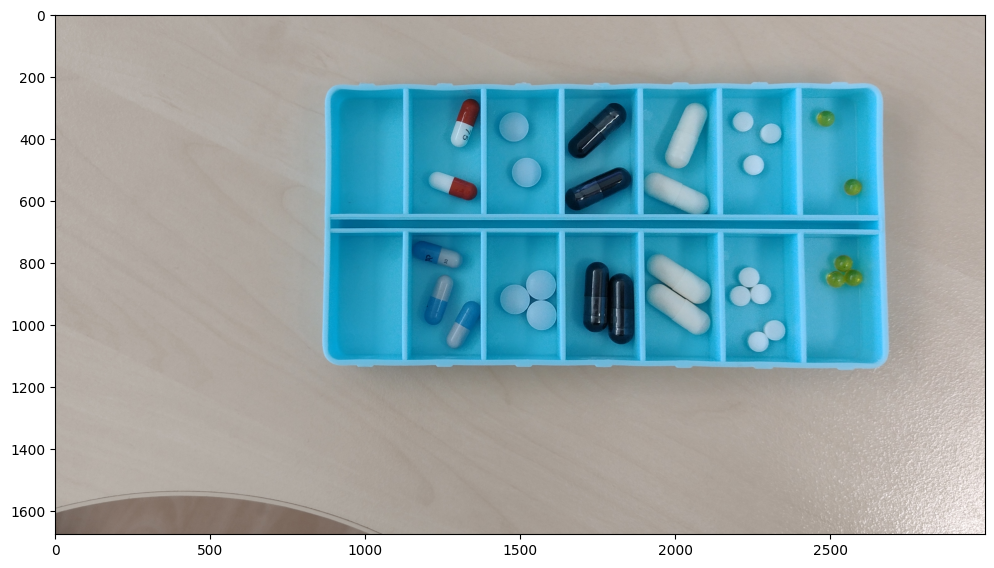

In [175]:
pills = cv2.imread("pills.png")[..., ::-1]
plt.subplots(1, 1, figsize=(12, 8))[1].imshow(pills)

In [176]:
pills_downsized = cv2.resize(pills, dsize=None, fx=0.5, fy=0.5)

In [177]:
# n_segments here needs to be HUGE - pills are tiny, and vanilla SLIC with square superpixels should give a tiny grid


# good results: sigma=1, n_segments=10000, compactness=12
@interact(sigma=(1, 20, 1), n_segments=(2, 10000, 1), compactness=(1, 100, 1))
def segment_pills(sigma, n_segments, compactness) -> None:
    segment_mask = slic(
        pills_downsized, n_segments=n_segments, compactness=compactness, sigma=sigma
    )
    boundaries = mark_boundaries(pills_downsized, segment_mask)
    plt.subplots(1, 1, figsize=(10, 10))[1].imshow(boundaries[100:600, 400:])
    plt.axis("off")
    plt.show()

interactive(children=(IntSlider(value=10, description='sigma', max=20, min=1), IntSlider(value=5001, descripti…

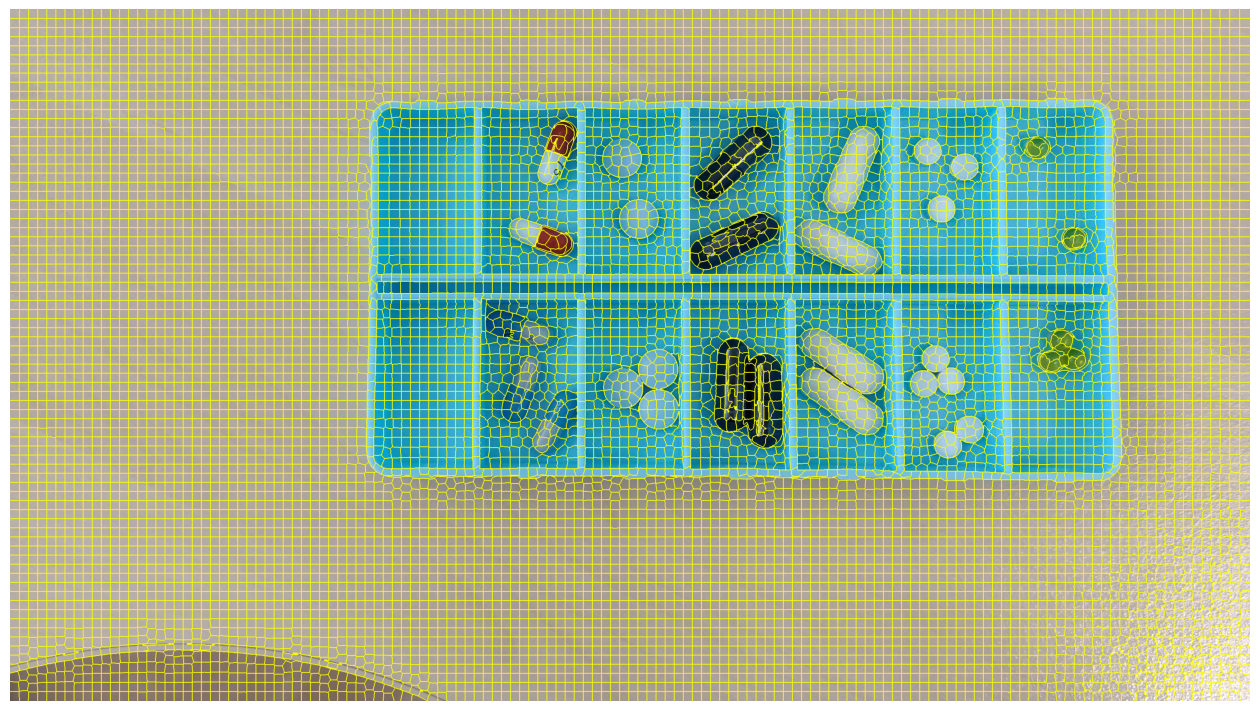

In [178]:
segment_mask = slic(pills, n_segments=10000, compactness=12, sigma=1)
boundaries = mark_boundaries(pills, segment_mask)
plt.subplots(1, 1, figsize=(16, 16))[1].imshow(boundaries)
plt.axis("off")
plt.show()

#### Zadanie 2

Dla obrazu `tabby` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie kota, drugi zawierający wyłącznie tło.

Można to zadanie potraktować jako binaryzację na poziomie superpikseli i zrealizować je za pomocą progowania. 
Można też potraktować je jako klasteryzację superpikseli i wykorzystać np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88).  
Niezależnie od wybranej ścieżki, konieczne będzie opisanie każdego z superpikseli za pomocą jakiejś *cechy* go opisującej (lub kilku cech). Najprostszymi cechami mogą być np. średnie wartości składowych barwy pikseli wchodzących w skład superpiksela.  
Do zastanowienia: jakie parametry SLICa wybrać jako podstawę w tym zadaniu?

Zaprezentuj wyniki albo za pomocą `mark_boundaries` albo wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać:  
```A[B==5] = 0```  
Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

---

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

/tmp/ipykernel_5582/3399003727.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


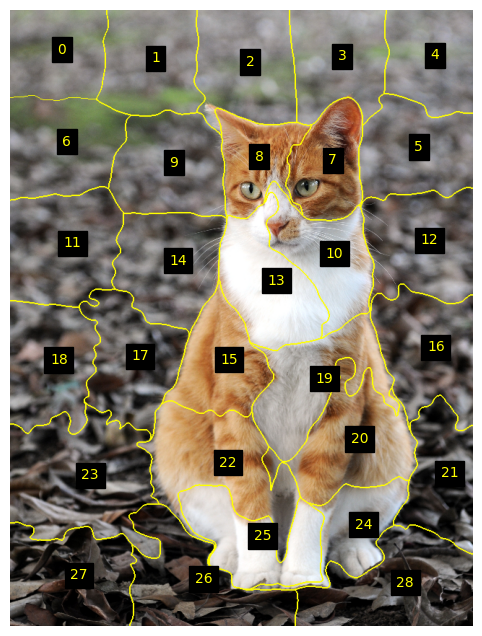

In [179]:
# slic params:
n_segments = 30
compactness = 30
sigma = 5

segment_mask = slic(
    tabby, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=0
)
boundaries = mark_boundaries(tabby, segment_mask)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(boundaries)
for i in np.unique(segment_mask):
    segment_center = np.mean(np.argwhere(segment_mask == i), axis=0)
    ax.text(
        segment_center[1],
        segment_center[0],
        str(i),
        color="yellow",
        backgroundcolor="black",
    )
ax.axis("off")
fig.show()


data_points = []
for segment_index in np.unique(segment_mask):
    superpixel = tabby[
        segment_mask == segment_index
    ]  # get all pixels of the superpixel, shape (N, 3), N = number of pixels in the superpixel

    mean_r = np.mean(superpixel[:, 0])
    mean_g = np.mean(superpixel[:, 1])
    mean_b = np.mean(superpixel[:, 2])
    std_r = np.std(superpixel[:, 0])
    std_g = np.std(superpixel[:, 1])
    std_b = np.std(superpixel[:, 2])

    superpixel_hsv = cv2.cvtColor(
        superpixel.reshape(-1, 1, 3), cv2.COLOR_RGB2HSV
    ).squeeze()

    mean_h = np.mean(superpixel_hsv[:, 0])
    mean_s = np.mean(superpixel_hsv[:, 1])
    mean_v = np.mean(superpixel_hsv[:, 2])
    data_points.append([mean_h, mean_s, mean_v])

data = np.array(data_points, dtype=np.float32)

In [180]:
from ipywidgets import IntSlider

data_rgb = cv2.cvtColor(
    data.reshape(-1, 1, 3).astype(np.uint8), cv2.COLOR_HSV2RGB
).squeeze()


# empirical studies show that only R value is important for the cat
@interact(
    min_h=IntSlider(min=0, max=180, step=1),
    max_h=IntSlider(min=0, max=180, step=1, value=180),
    min_s=IntSlider(min=0, max=255, step=1),
    max_s=IntSlider(min=0, max=255, step=1, value=255),
    min_v=IntSlider(min=0, max=255, step=1),
    max_v=IntSlider(min=0, max=255, step=1, value=255),
    min_r=IntSlider(min=0, max=255, step=1),
    max_r=IntSlider(min=0, max=255, step=1, value=255),
    min_g=IntSlider(min=0, max=255, step=1),
    max_g=IntSlider(min=0, max=255, step=1, value=255),
    min_b=IntSlider(min=0, max=255, step=1),
    max_b=IntSlider(min=0, max=255, step=1, value=255),
)
def threshold(
    min_h, max_h, min_s, max_s, min_v, max_v, min_r, max_r, min_g, max_g, min_b, max_b
):

    indexes = np.argwhere(
        (data[:, 0] >= min_h)
        & (data[:, 0] <= max_h)
        & (data[:, 1] >= min_s)
        & (data[:, 1] <= max_s)
        & (data[:, 2] >= min_v)
        & (data[:, 2] <= max_v)
        & (data_rgb[:, 0] >= min_r)
        & (data_rgb[:, 0] <= max_r)
        & (data_rgb[:, 1] >= min_g)
        & (data_rgb[:, 1] <= max_g)
        & (data_rgb[:, 2] >= min_b)
        & (data_rgb[:, 2] <= max_b)
    )
    # print(data[indexes.flatten()])

    tabby_segmented = np.zeros_like(tabby)
    for i in indexes.flatten():
        tabby_segmented[segment_mask == i] = tabby[segment_mask == i]

    plt.subplots(1, 1, figsize=(8, 8))[1].imshow(tabby_segmented)

interactive(children=(IntSlider(value=0, description='min_h', max=180), IntSlider(value=180, description='max_…